# Image Analysis: Using bag of visual words for scene classification.

## Introduction

### First Part: How do we extract features?

Before extracting features we need to get our hands into a dataset and import the necessary packages. The dataset I used for this project was Caltech 101 with 101 categories, it can be found in the `Caltech101` folder. To download it go to [their website](http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html). I also used the **OpenCV Python Package (3.4.1)** in the implementation of this project, to download any version, go to [the official OpenCV website](https://opencv.org/releases.html); other essential packages for Computer Vision, Machine Learning and utilities packages were used such as `numpy`, `os`, `matplotlib` and others.

In [1]:
# Import modules
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
import confmat as cfmat
import cv2 as cv
import numpy as np
import os
from imutils import paths
import pickle
%matplotlib inline

### Part 2. Getting all the categories based on a given path

For the purpose of brevity, simplicity and computational "cheapness" I am going to use 3 categories, however, the original Caltech database contains 101 categories for image classification. This algorithm can easily be expanded or scaled into any number of categories, although more efficient approaches may be needed for fast computation of the classification task.

In [2]:
dataset_path = '../data/upf/training_set/'
categories = os.listdir(dataset_path)
print("Training path: ", dataset_path)
print("Training categories: ", categories)

Training path:  ../data/upf/training_set/
Training categories:  ['aeroplane', 'bicycle', 'car']


In [3]:
# Get all the path to the images and save them in a list
# image_paths and the corresponding label in image_paths
# The path is defined in the `train_path` variable.
# Also, the label is just a number in this case.
image_paths = []
image_classes = []
class_id = 0
for category in categories:
    dir = os.path.join(dataset_path, category)
    class_path = list(paths.list_images(dir)) # This is the path to all the images given A SINGLE CLASS
    # Stores the path to all the images in the images_paths variable which has all of the training images.
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path) # Assigns a label to each image path
    class_id+=1
print(image_classes)
print(len(image_classes))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
51


### Part 3. Combine Part 1 and Part 2 to detect the Keypoints and Descriptors of all of the images

#### SIFT Note: 

Even though SIFT has different parameters, the paper by Lowe gives some empirical data which can be summarized as, number of octaves = 4, number of scale levels = 5, initial $\sigma = 1.6$, $k = \sqrt{2}$ etc as optimal values.

In [4]:
# Detect SIFT Keypoints
sift        = cv.xfeatures2d.SIFT_create()
# List where all the descriptors will be stored
des_list = []
print("Calculating all the descriptors and keypoints...")
for image_path in image_paths:
    print("Calculating for image ["+ image_path +"]           ", end="\r")
    im  = cv.imread(image_path)
    gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY) # Converts from one color space to another (grayscale)
    kp, des = sift.detectAndCompute(gray,None)
    des_list.append((image_path, kp, des))
print("\nDone!")

Calculating all the descriptors and keypoints...
Calculating for image [../data/upf/training_set/car\9.jpg]                  
Done!


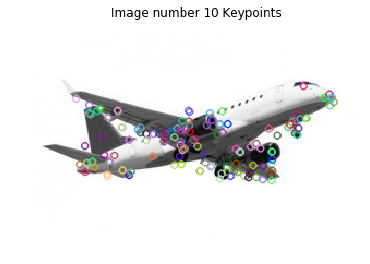

In [5]:
# Example for the 3rd image
IMAGE_N = 10
im = cv.imread(des_list[IMAGE_N][0])
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
kp, des = sift.detectAndCompute(gray, None)
kpImg = cv.drawKeypoints(gray, kp, im)
plt.imshow(im, cmap='gray')
plt.axis("off")
plt.title("Image number "+str(IMAGE_N)+" Keypoints")
plt.show()

In [6]:
# Stack all the descriptors vertically in a numpy array
print("Stacking all the descriptors in a numpy array...")
descriptors = des_list[0][2]
for image_path, keypoints, descriptor in des_list[1:]:
    print("Calculating for image ["+ image_path +"]           ", end="\r")
    descriptors = np.vstack((descriptors, descriptor))
print("\nDone!")

Stacking all the descriptors in a numpy array...
Calculating for image [../data/upf/training_set/car\9.jpg]                  
Done!


#### Optional. Save the descriptors variable in an external file.

In [7]:
pickle.dump(descriptors, open('descriptors.sav', 'wb'))

### Part 4. Apply K-means

In [17]:
# Perform k-means clustering
k = 500
voc, variance = kmeans(descriptors, k, 1)
print("Done doing K-means")

Done doing K-means


In [18]:
# Create the histogram itself of the image features
im_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    print("Calculating distance for image "+str(i)+"...", end="\r")
    words, distance = vq(des_list[i][2],voc)
    for w in words:
        im_features[i][w] += 1

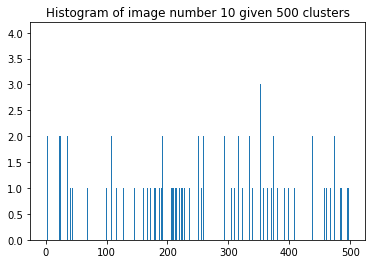

In [19]:
plt.bar(range(k), im_features[IMAGE_N])
plt.title("Histogram of image number "+ str(IMAGE_N) +" given "+ str(k) + " clusters")
plt.show()

The number of times a term occurs in a document is called its **term frequency**. Is a way of weighting documents given a list of the words that form the document. That is, if a word appears a lot in a document, it may be important. Further weighting schemas can be done as well, such as the _inverse document frequency_. Given the term $t$ and its frequency in a document $i$, its **term frequency $tf_i$** is:

$$tf_i = t \cdot f_i$$

One can define the **document frequency** or $df_i$ as the number of occurences that any given term appears in a group of documents, hence the name. The **inverse document frequency** is a weighting scheme that takes into account the document frequency to apply weights to each word. Because, if a certain word appears in all of the documents, is not a discriminative word. The $idf_i$ weighting schema has the following equation:

$$idf_i = \log{\frac{N}{df_i}}$$

Where $N$ is the total number of documents, and thus, if the document frequency is low, it's a rare word which has a high weight.

### IDF

Given the earlier definition, let's implement this weighting schema. Let $idf_i$ be a $K$-vector. Where $K$ is the number of clusters or words. Then: 

$$idf_i = \log{\frac{N}{n_i}}$$

Where $N$ is the number of documents or images, and $n_i$ is the number of documents that contain the term $i$.

$N$ then can be computed as: `len(des_list)`

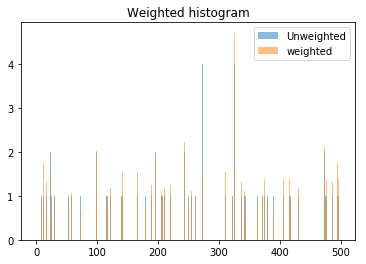

In [20]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths) + 1) / (1.0*nbr_occurences + 1)), 'float32')
scaled_im_features = im_features * idf
plt.bar(range(k), im_features[IMAGE_N], alpha=0.5)
plt.bar(range(k), scaled_im_features[IMAGE_N], alpha=0.5)
plt.title("Weighted histogram")
plt.legend(['Unweighted', 'weighted'])
plt.show()

#### Feature normalization or scaling
The standard scaler allows us to normalize our already tf-idf weighted feature vector for each document (image).

In [21]:
# Scaling the words
stdSlr = StandardScaler().fit(scaled_im_features)
scaled_im_features = stdSlr.transform(scaled_im_features)

### Part 5. Train a Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
clf = DecisionTreeClassifier(max_depth=None, random_state=0)
baggingclf = BaggingClassifier(RandomForestClassifier())
cv = cross_validate(baggingclf, X=scaled_im_features, y=image_classes, return_train_score=True, cv=10)
print("Training Score: ", cv['train_score'].mean())
print("Mean cross-validation score: ", cv['test_score'].mean())
clf.fit(X=scaled_im_features, y=image_classes)

Training Score:  0.9977777777777778
Mean cross-validation score:  0.8833333333333334


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [23]:
clf = LinearSVC()
cv = cross_validate(clf, X=scaled_im_features, y=image_classes, return_train_score=True, cv=5)
print("Training Score: ", cv['train_score'].mean())
print("Mean cross-validation score: ", cv['test_score'].mean())
clf.fit(X=scaled_im_features, y=image_classes)

Training Score:  1.0
Mean cross-validation score:  0.7999999999999999


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [24]:
# Save the SVM
joblib.dump((clf, categories, stdSlr, k, voc, idf), "svm.pkl", compress=3)

['svm.pkl']